In [41]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score, accuracy_score
import pickle

In [42]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADEGOKE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
df = pd.read_csv("../datasets/raw/reviews.csv")

In [44]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [45]:
import re
df["review"] = df["review"].apply(lambda x: re.sub(r"<.*?>", "", x))
df["review"] = df["review"].apply(lambda x: x.lower())

In [46]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [47]:
df["sentiment"] = df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)

In [48]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [49]:
df["sentiment"].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [50]:
stopset = stopwords.words("english")

In [51]:
vectorizer = TfidfVectorizer(use_idf=True, strip_accents="ascii", stop_words=stopset, ngram_range=(1, 2))

In [52]:
X = vectorizer.fit_transform(df["review"])
y = df["sentiment"]
pickle.dump(vectorizer, open("../models/transformed.pkl", "wb"))

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [58]:
models = {
    "Naive Bayes": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "Linear SVM": LinearSVC()
}

results = {}

for name, model in models.items():
    
    print(f"Training {name}...")
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    try:
        if hasattr(model, "predict_proba"):
            prob = model.predict_proba(X_test)[:, 1]
        else:
            prob = model.decision_function(X_test)

        roc = roc_auc_score(y_test, prob)

    except:
        roc = None

    results[name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC-AUC": roc
    }

results_df = pd.DataFrame(results).T
results_df_percent = results_df*100
print(results_df_percent)

Training Naive Bayes...
Training LogisticRegression...
Training Linear SVM...
                    Accuracy  Precision  Recall   F1-score    ROC-AUC
Naive Bayes            88.88  89.098954   88.60  88.848777  95.582180
LogisticRegression     89.61  88.598714   90.92  89.744349  96.070740
Linear SVM             91.19  90.597280   91.92  91.253847  97.030312


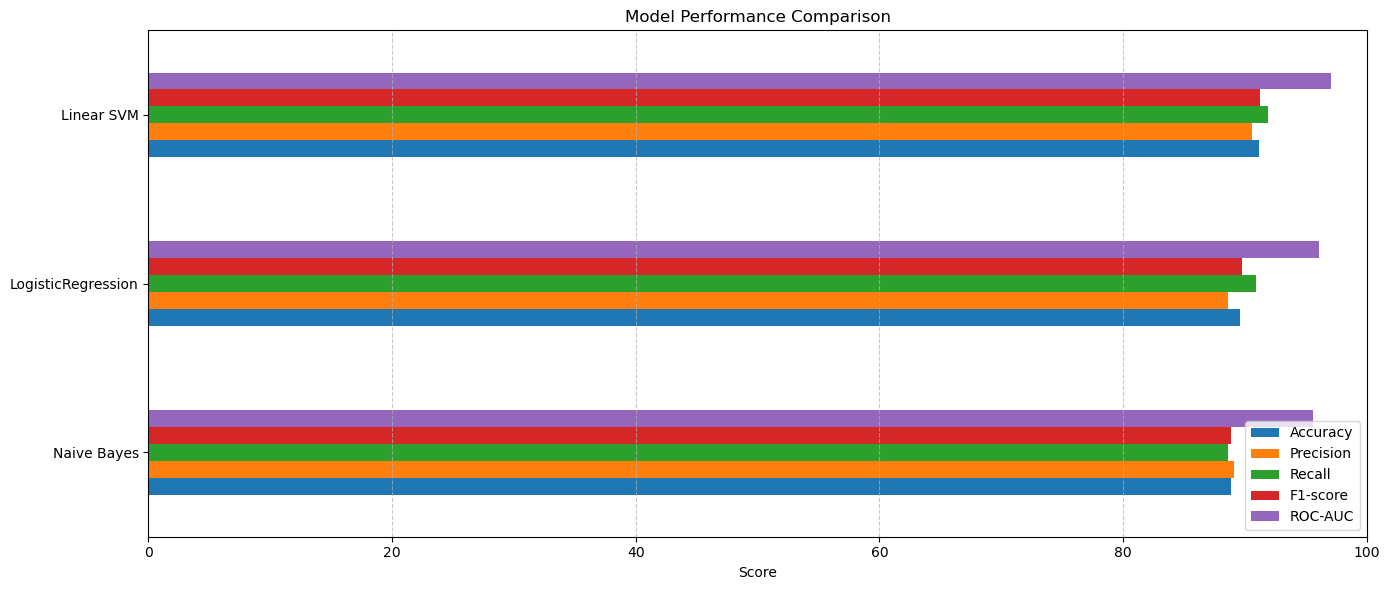

In [59]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]

results_df_percent
results_df_percent[metrics].plot(kind="barh", figsize=(14, 6))

plt.title("Model Performance Comparison")
plt.xlabel("Score")
plt.xlim(0,100)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [60]:
best_model = LinearSVC(C=2, max_iter=2000)
best_model.fit(X, y)
pickle.dump(best_model, open("../models/comment.pkl", "wb"))